xwOBA Model

Part 1 - Data collection

In [41]:
from pybaseball import statcast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

For this project, I'll be using three years of data. This way it is recent, but is still measured prior to the 2023 rule changes.

In [21]:
three_year_data = statcast(start_dt="2020-07-23", end_dt="2022-11-05")

This is a large query, it may take a moment to complete


C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates
Skipping offseason dates


100%|████████████████████████████████████████████████████████████████████████████████| 579/579 [07:05<00:00,  1.36it/s]


Since I'm designing a process to find xwOBAcon, I'm only using balls in play.

In [42]:
contact_data = three_year_data[three_year_data['description'] == 'hit_into_play']
contact_data

pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
192         SL 2022-11-05           89.2          -0.06           6.14   
200         FF 2022-11-05           93.9          -0.18           5.94   
212         FF 2022-11-05           93.0          -0.09           5.97   
215         SL 2022-11-05           88.1          -0.15           6.03   
141         KC 2022-11-05           86.4          -2.67           5.86   
..         ...        ...            ...            ...            ...   
371         FF 2020-07-23           96.4          -1.94           5.56   
256         FF 2020-07-23           95.9          -3.16           5.49   
278         SL 2020-07-23           86.7          -3.27           5.32   
340         FF 2020-07-23           96.7          -3.26           5.44   
370         FF 2020-07-23           96.1          -3.28           5.13   

          player_name  batter  pitcher     events    description  ...  \
192     Pressly, Ryan  592206   519151  field_out  hit_into_play  ...   
200     Pressly, Ryan  547180   519151  field_out  hit_into_play  ...   
212     Pressly, Ryan  592663   519151     single  hit_into_play  ...   
215     Pressly, Ryan  656555   519151  field_out  hit_into_play  ...   
141  Robertson, David  663656   502085  field_out  hit_into_play  ...   
..                ...     ...      ...        ...            ...  ...   
371      Cole, Gerrit  607208   543037  field_out  hit_into_play  ...   
256     Scherzer, Max  519317   453286   home_run  hit_into_play  ...   
278     Scherzer, Max  650402   453286  field_out  hit_into_play  ...   
340     Scherzer, Max  592450   453286     single  hit_into_play  ...   
370     Scherzer, Max  543305   453286  field_out  hit_into_play  ...   

     fld_score  post_away_score  post_home_score  post_bat_score  \
192          4                1                4               1   
200          4                1                4               1   
212          4                1                4               1   
215          4                1                4               1   
141          1                1                4               4   
..         ...              ...              ...             ...   
371          2                2                0               0   
256          0                2                0               2   
278          0                0                0               0   
340          0                0                0               0   
370          0                0                0               0   

     post_fld_score if_fielding_alignment of_fielding_alignment spin_axis  \
192               4              Standard              Standard       137   
200               4         Infield shift              Standard       210   
212               4              Standard              Standard       212   
215               4         Infield shift              Standard       120   
141               1         Infield shift              Standard        47   
..              ...                   ...                   ...       ...   
371               2              Standard              Standard       225   
256               0              Standard              Standard       222   
278               0         Infield shift              Standard       124   
340               0         Infield shift              Standard       220   
370               0         Infield shift              Standard       227   

    delta_home_win_exp delta_run_exp  
192              0.011        -0.219  
200              0.022          -0.3  
212              -0.02         0.262  
215              0.018        -0.158  
141             -0.001         -0.07  
..                 ...           ...  
371             -0.022        -0.414  
256              -0.18         1.787  
278              0.018        -0.335  
340             -0.025         0.272  
370              0.022        -0.216  

[319934 rows x 92 columns]

Preliminary scatter plot of exit velocity and launch angle, colored by type of ball in play.

In [43]:
contact_data = contact_data.dropna(subset = ['launch_angle', 'launch_speed'])

Text(0.5, 0, 'Exit Velocity (mph)')

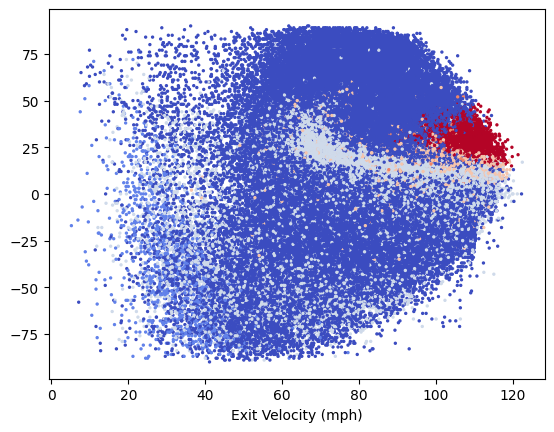

In [44]:
fig, ax = plt.subplots()
plt.scatter(x = contact_data['launch_speed'], y = contact_data['launch_angle'],
           c = contact_data['woba_value'], cmap = 'coolwarm', s = 2)
ax.set_xlabel('Exit Velocity (mph)')

To make it easier on our model, I am going to make every type of ball in play with a wOBA of 0 into "out." I also will be excluding catcher's interference because the swings were interfered with.

In [45]:
contact_data = contact_data.replace(['field_out', 'force_out', 'grounded_into_double_play', 
                                               'fielders_choice_out', 'sac_fly', 'field_error', 'sac_bunt_double_play',
                                              'fielders_choice', 'sac_bunt', 'double_play', 'triple_play',
                                              'sac_fly_double_play'], 'out')

In [48]:
contact_data.drop(contact_data[contact_data['events'] == 'catcher_interf'].index, inplace = True)

In [49]:
contact_data

pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
192         SL 2022-11-05           89.2          -0.06           6.14   
200         FF 2022-11-05           93.9          -0.18           5.94   
212         FF 2022-11-05           93.0          -0.09           5.97   
215         SL 2022-11-05           88.1          -0.15           6.03   
141         KC 2022-11-05           86.4          -2.67           5.86   
..         ...        ...            ...            ...            ...   
371         FF 2020-07-23           96.4          -1.94           5.56   
256         FF 2020-07-23           95.9          -3.16           5.49   
278         SL 2020-07-23           86.7          -3.27           5.32   
340         FF 2020-07-23           96.7          -3.26           5.44   
370         FF 2020-07-23           96.1          -3.28           5.13   

          player_name  batter  pitcher    events    description  ...  \
192     Pressly, Ryan  592206   519151       out  hit_into_play  ...   
200     Pressly, Ryan  547180   519151       out  hit_into_play  ...   
212     Pressly, Ryan  592663   519151    single  hit_into_play  ...   
215     Pressly, Ryan  656555   519151       out  hit_into_play  ...   
141  Robertson, David  663656   502085       out  hit_into_play  ...   
..                ...     ...      ...       ...            ...  ...   
371      Cole, Gerrit  607208   543037       out  hit_into_play  ...   
256     Scherzer, Max  519317   453286  home_run  hit_into_play  ...   
278     Scherzer, Max  650402   453286       out  hit_into_play  ...   
340     Scherzer, Max  592450   453286    single  hit_into_play  ...   
370     Scherzer, Max  543305   453286       out  hit_into_play  ...   

     fld_score  post_away_score  post_home_score  post_bat_score  \
192          4                1                4               1   
200          4                1                4               1   
212          4                1                4               1   
215          4                1                4               1   
141          1                1                4               4   
..         ...              ...              ...             ...   
371          2                2                0               0   
256          0                2                0               2   
278          0                0                0               0   
340          0                0                0               0   
370          0                0                0               0   

     post_fld_score if_fielding_alignment of_fielding_alignment spin_axis  \
192               4              Standard              Standard       137   
200               4         Infield shift              Standard       210   
212               4              Standard              Standard       212   
215               4         Infield shift              Standard       120   
141               1         Infield shift              Standard        47   
..              ...                   ...                   ...       ...   
371               2              Standard              Standard       225   
256               0              Standard              Standard       222   
278               0         Infield shift              Standard       124   
340               0         Infield shift              Standard       220   
370               0         Infield shift              Standard       227   

    delta_home_win_exp delta_run_exp  
192              0.011        -0.219  
200              0.022          -0.3  
212              -0.02         0.262  
215              0.018        -0.158  
141             -0.001         -0.07  
..                 ...           ...  
371             -0.022        -0.414  
256              -0.18         1.787  
278              0.018        -0.335  
340             -0.025         0.272  
370              0.022        -0.216  

[302617 rows x 92 columns]

Part 2 - Baseline model

Now that our data is set up, we can create our baseline model for xwOBAcon.

In [50]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [51]:
X = contact_data[["launch_speed", "launch_angle"]]
Y = contact_data[['events']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = .2)

We have to scale the results because exit velocity can be any positive number, while launch angle can only be between -90 and 90. This will give us a clearer, more accurate neighborhood.

In [52]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [53]:
classifier = KNeighborsClassifier(n_neighbors = 23, p = 2, metric = 'euclidean', )

In [54]:
classifier.fit(X_train, Y_train)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=23)

In [55]:
Y_pred = classifier.predict(X_test)

In [56]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[  627   287  1927  1107     0]
 [  158  1970   755     0     0]
 [  483   458 37393  2497     0]
 [  190    19  5932  6394     0]
 [   43    48   164    72     0]]


In [57]:
classifier.predict_proba(X_test)

array([[0.2173913 , 0.        , 0.        , 0.73913043, 0.04347826],
       [0.        , 0.        , 0.7826087 , 0.2173913 , 0.        ],
       [0.        , 0.        , 0.82608696, 0.17391304, 0.        ],
       ...,
       [0.04347826, 0.        , 0.91304348, 0.04347826, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.73913043, 0.26086957, 0.        ]])

In [58]:
print(accuracy_score(Y_test, Y_pred))

0.766373669949111


Part 3 - Assessing the model

Here we will take a closer look at our model and evaluate it a little bit, starting with the log loss metric.

In [59]:
from sklearn.metrics import log_loss
log_loss(Y_test, Y_pred)

ValueError: could not convert string to float: 'single'

In [40]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Expected 'estimator' to be a binary classifier. Got 6 classes instead.

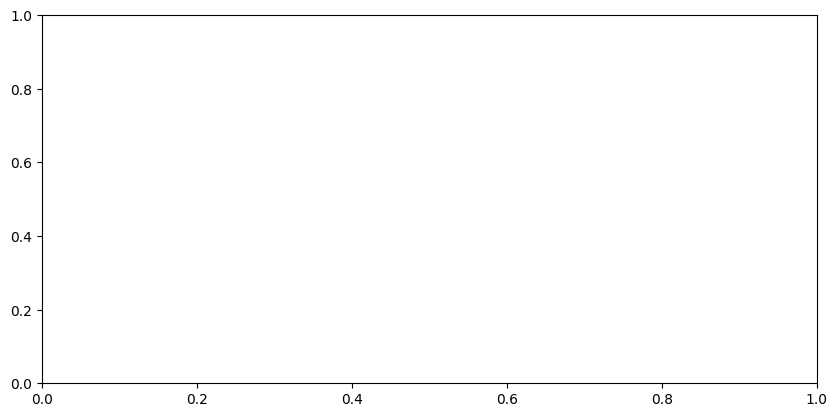

In [41]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, Y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        Y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].Y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [67]:
pred_df = pd.DataFrame(classifier.predict_proba(X_test), columns=['out', 'single', 'double', 'triple', 'home_run'])
combined_df = pd.concat([X_test, pred_df], axis=1)
combined_df["output"] = list(Y_test)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid